In [60]:
import time
from pathlib import Path
import numpy as np
from test import Map
import cv2
import matplotlib.pyplot as plt
from ROAR.utilities_module.data_structures_models import Location
from tqdm import tqdm
%matplotlib inline



## Construct map

In [61]:
dir_path = Path("./data/pointcloud_1")
print(f'reading point cloud from {dir_path}')
pcd = Map.read_pointclouds(dir_path=dir_path)
print(f"{pcd} constructed")
scale = 15
buffer = 0
x_offset, y_offset, x_width, y_height = Map.find_hyperparam_from_pcd(pcd=pcd, scale=scale, buffer=buffer)
m = Map(
    x_offset=x_offset, y_offset=y_offset, x_scale=scale, y_scale=scale,
    x_width=x_width, y_height=y_height, buffer=buffer, name="occu_map"
)
points = Map.extract_xz_points_from_pcd(pcd)
m.update(points=points)
# m.visualize()

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(m.map,kernel,iterations = 1)


occu_map = np.ones(shape=(dilation.shape[0], dilation.shape[1]), dtype=np.float32)
occu_map[np.where(dilation > 0.5)] = 0
# plt.imshow(occu_map,cmap='gray')
# plt.show()


nav_map = np.zeros(shape=(occu_map.shape[0], occu_map.shape[1], 3),
                   dtype=np.uint8)
nav_map[np.where(occu_map > 0.5)] = np.array([255, 255, 255]).astype(np.uint8)
# plt.imshow(nav_map)
# plt.show()

reading point cloud from data/pointcloud_1


100%|██████████| 686/686 [00:12<00:00, 55.40it/s]

PointCloud with 131855 points. constructed


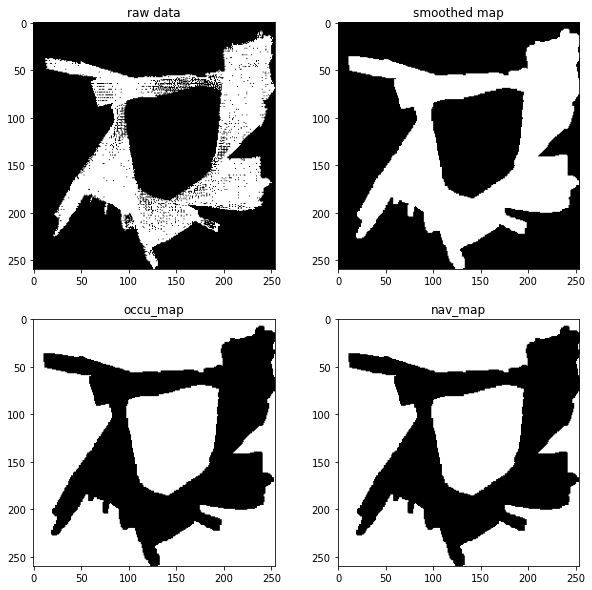

In [62]:
%matplotlib inline
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0][0].imshow(m.map, cmap="gray")
axes[0][0].set_title("raw data")

axes[0][1].imshow(dilation, cmap="gray")
axes[0][1].set_title("smoothed map")

axes[1][0].imshow(occu_map, cmap="gray")
axes[1][0].set_title("occu_map")

axes[1][1].imshow(nav_map)
axes[1][1].set_title("nav_map")

plt.show()

In [63]:
def draw_dot(data:np.ndarray, pos: np.ndarray, buf:int=2, val=None):
    data = data.copy()
    if val is None:
        val = [0, 0, 255]
    data[pos[1] - buf : pos[1] + buf,pos[0] - buf : pos[0] + buf] = val
    return data

def plot(data: np.ndarray, cmap=None):
    plt.imshow(data, cmap)
    # plt.show()

## Draw out start and end destinations

Text(0.5, 1.0, 'nav_map with start and end plotted')

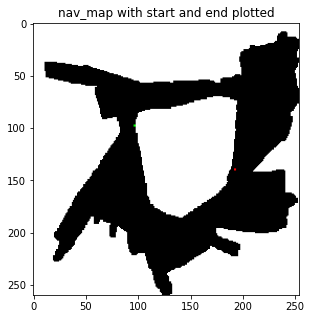

In [64]:
start_loc:Location = Location.from_array(np.array([-1.1319398,0.02977551,0.3790202]))
end_loc: Location = Location.from_array(np.array([-7.5140696,-0.04548472,-2.4632778]))
start_loc_occu = m.world_loc_to_occu_map_coord(start_loc)
end_loc_occu = m.world_loc_to_occu_map_coord(end_loc)
nav_map = draw_dot(data=nav_map, pos=end_loc_occu, buf=1, val=[0,255,0])
nav_map = draw_dot(data=nav_map, pos=start_loc_occu, buf=1, val=[255,0,0])
%matplotlib inline
fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(nav_map)
axes.set_title("nav_map with start and end plotted")

## Potential Field Planning

1. calculate repulsive map
    for every obstacle, for a distance D pixels around it, give it incrementally negative reward

2. calculate attractive map
    for every pixel, calculate its distance from goal, give it incremental positive reward based on distance

3. gradient ascend on the combined repulsive and attractive map

In [139]:
def calc_repulsive(pmap:np.ndarray, occu_map:np.ndarray,
                   obstacle_influence_distance:int=5,
                   obstacle_weight:float=-1) -> np.ndarray:
    import itertools
    pmap = pmap.copy()
    obstacle_coords = np.where(occu_map > 0.5)
    obstacle_offsets = np.arange(-obstacle_influence_distance, obstacle_influence_distance, 1)
    print(f"Calculating repulsive forces", end=" ")
    for coord in tqdm(list(zip(*obstacle_coords))):
        x, y = coord
        for d in range(1, obstacle_influence_distance):
            xs = x + obstacle_offsets
            ys = y + obstacle_offsets
            coords = np.array(list(itertools.product(xs, ys)))
            x_mask = (coords[:, 0] >= 0) & (coords[:, 0] < pmap.shape[0])
            y_mask = (coords[:, 1] >= 0) & (coords[:, 1] < pmap.shape[1])
            mask = np.all([x_mask, y_mask], axis=0)
            coords = coords[mask]
            pmap[coords[:, 0], coords[:, 1]] += obstacle_weight
    return pmap

def calc_attractive(pmap: np.ndarray, gx:int, gy:int, attractive_weight: float = 0.5):
    print(f"Calculating attractive forces", end=" ")
    indices = np.indices(pmap.shape)
    xs = indices[1, :].reshape(pmap.shape[0]*pmap.shape[1]) - gx
    ys = indices[0, :].reshape(pmap.shape[0]*pmap.shape[1]) - gy
    attractive_map = (np.hypot(xs, ys) * attractive_weight).reshape(pmap.shape)
    return attractive_map

construct repulsive and attractive maps

In [140]:
pmap = np.zeros(shape=(nav_map.shape[0], nav_map.shape[1]))
repulsive_map = calc_repulsive(pmap=pmap, occu_map=occu_map,
                               obstacle_influence_distance=6,
                               obstacle_weight=-5)


Calculating repulsive forces 

100%|██████████| 41453/41453 [00:19<00:00, 2165.89it/s]


In [141]:
attractive_map = calc_attractive(pmap=pmap, gx=end_loc_occu[0], gy=end_loc_occu[1],
                                 attractive_weight=10)

Calculating attractive forces 

In [142]:
pmap = attractive_map + repulsive_map
print("potential field Done!")

potential field Done!


Text(0.5, 1.0, 'Total Cost map')

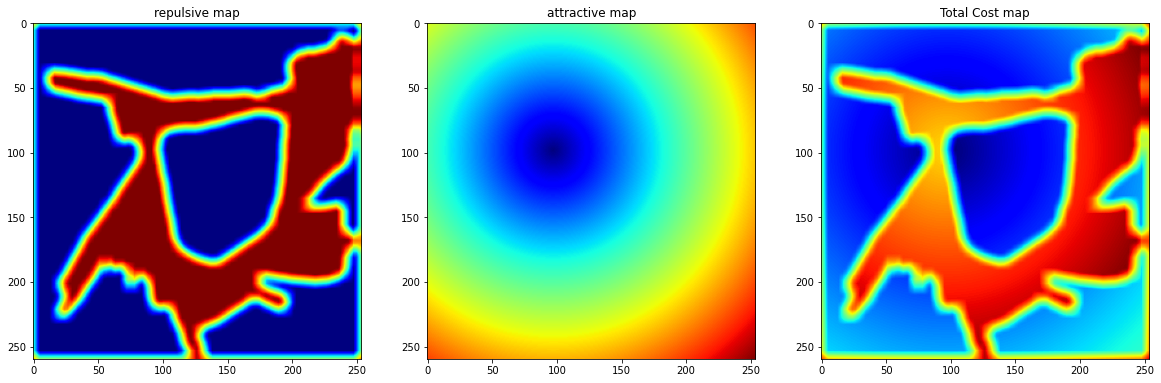

In [143]:
%matplotlib inline
fig, axes = plt.subplots(1,3, figsize=(20,20))
axes[0].imshow(repulsive_map, cmap="jet")
axes[0].set_title("repulsive map")

axes[1].imshow(attractive_map, cmap="jet")
axes[1].set_title("attractive map")

axes[2].imshow(pmap, cmap="jet")
axes[2].set_title("Total Cost map")

In [144]:
def compute_cost(cx, cy, ex, ey):
    return np.hypot(cx-ex, cy-ey)

In [161]:
motion = 5*np.array([
                    [1, 0],
                    [0, 1],
                    [-1, 0],
                    [0, -1],
                    [-1, -1],
                    [-1, 1],
                    [1, -1],
                    [1, 1]]).astype(int)

In [162]:
show_animation = True
distance_threshold = 8

rx, ry = [], []

cx, cy = start_loc_occu
ex, ey = end_loc_occu
cd = compute_cost(cx,cy,ex,ey)
nav_map_tmp = nav_map.copy()
visited = set()
visited.add((cx, cy))
counter = 0

if show_animation:
    %matplotlib
    fig, axes = plt.subplots(figsize=(5,5))
    axes.imshow(nav_map_tmp, cmap="jet")

while abs(cd) > distance_threshold:
    # print(f"{counter} entering -> {cx, cy}")
    log = []

    # find the correct motion
    for i, m in enumerate(motion): # TODO generate motion that correspond to vehicle's model
        ix = cx + int(m[0])
        iy = cy + int(m[1])
        if 0 <= ix < pmap.shape[0] and 0 <= iy < pmap.shape[1] and occu_map[iy][ix] == 0:
            cost = pmap[iy][ix]
            log.append((cost, ix, iy))
        else:
            pass
    log = sorted(log, key=lambda x: x[0])
    found_next_node = False
    for l in log:
        _, new_cx, new_cy = l
        # print(f"seeing if {(new_cx, new_cy)} has been visited")
        if (new_cx, new_cy) not in visited:
            # print(f"moving from {cx, cy} to {new_cx, new_cy}")
            cx, cy = new_cx, new_cy
            found_next_node = True
            break

    if found_next_node is False:
        print("Oscillation detected. Exiting...")
        break
    else:
        cd = compute_cost(cx, cy, ex, ey)
        visited.add((cx, cy))

    rx.append(cx)
    ry.append(cy)
    # nav_map_tmp = draw_dot(nav_map_tmp, pos=np.array([cx, cy]), val=[0,0,255], buf=1)

    if show_animation:
        axes.plot(cx, cy, ".b")
        plt.pause(0.01)

    counter += 1
    # if counter == 100:
    #     break

Using matplotlib backend: MacOSX
